# t-SNE visualization

This notebook visualizes the trained EEG embeddings.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_class_wise_metrics
from train.visualize import draw_error_table
from train.visualize import annotate_heatmap

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_name = 'fq3sat1x'
model_path = os.path.join(r'E:\CAUEEG\checkpoint', model_name, 'checkpoint.pt')

ckpt = torch.load(model_path, map_location=device)
print(ckpt.keys())

dict_keys(['model_state', 'config', 'optimizer_state', 'scheduler_state'])


In [5]:
model_state = ckpt['model_state']
config = ckpt['config']
optimizer = ckpt['optimizer_state']
scheduler = ckpt['scheduler_state']

In [6]:
pprint.pprint(config, width=250)

{'EKG': 'O',
 '_target_': 'models.resnet_2d.ResNet2D',
 'activation': 'relu',
 'age_mean': tensor([71.2670], device='cuda:0'),
 'age_std': tensor([9.3171], device='cuda:0'),
 'awgn': 0.04820207830923446,
 'awgn_age': 0.16811608741676137,
 'base_channels': 64,
 'base_lr': 0.0020000000000000005,
 'block': 'bottleneck',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [3, 4, 6, 3],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'cwd': '/home/minjae/Desktop/eeg_analysis',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/02_Curated_Data_220419/',
 'ddp': False,
 'device': device(type='cuda'),
 'draw_result': True,
 'dropout': 0.16113930908903867,
 'fc_stages': 5,
 'file_format': 'memmap',
 'groups': 32,
 'in_channels': 40,
 'input_norm': 'dataset',
 'iterations': 625000,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_warm

-----

## Load the target model

In [7]:
# model = config['generator'](**config).to(device)
model = hydra.utils.instantiate(config).to(device)

if config.get('ddp', False):
    model_state_ddp = deepcopy(model_state)
    model_state = OrderedDict()
    for k, v in model_state_ddp.items():
        name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
        model_state[name] = v
    model.load_state_dict(model_state)
else:
    model.load_state_dict(model_state)

-----

## Evaluate the model and analyze the performance by the crop timing

### Configurations

In [8]:
config = ckpt['config']

config.pop('cwd', 0)
config['ddp'] = False
config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

### Build Dataset

In [9]:
train_loader, val_loader, test_loader, multicrop_test_loader = build_dataset_for_train(config, verbose=True)

transform: Compose(
    EegRandomCrop(crop_length=2000, length_limit=10000000, multiple=4, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

transform_multicrop: Compose(
    EegRandomCrop(crop_length=2000, length_limit=10000000, multiple=8, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------


task config:
{'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'task_description': 'Classification of [Normal], [MCI], and [Dementia] '
                     'symptoms.',
 'task_name': 'CAUEEG-Dementia benchmark'}

 ---------------------------------------------------------------------------------------------------- 

train_dataset[0].keys():
dict_k

In [125]:
@torch.no_grad()
def compute_embedding(model, sample_batched, preprocess, crop_multiple=1, target_from_last=1):
    # evaluation mode
    model.eval()
    
    # preprocessing (this includes to-device operation)
    preprocess(sample_batched)

    # apply model on whole batch directly on device
    x = sample_batched['signal']
    age = sample_batched['age']
    e = model.compute_feature_embedding(x, age, target_from_last=target_from_last)
    y = sample_batched['class_label']
    
    if crop_multiple > 1:
        # multi-crop averaging
        if e.size(0) % crop_multiple != 0:
            raise ValueError(f"compute_embedding(): Real minibatch size={e.size(0)} is not multiple of "
                             f"crop_multiple={crop_multiple}.")

        real_minibatch = e.size(0) // crop_multiple
        e_ = torch.zeros((real_minibatch, e.size(1)))
        y_ = torch.zeros((real_minibatch,), dtype=torch.int32)

        for m in range(real_minibatch):
            e_[m] = e[crop_multiple*m:crop_multiple*(m + 1)].mean(dim=0, keepdims=True)
            y_[m] = y[crop_multiple*m]
                
        e = e_
        y = y_
    
    return e, y

In [126]:
target_symptom = {'mci_amnestic_ef': [], 'mci_amnestic_rf': []}

for i, sample_batched in enumerate(train_loader):
    crop_multiple = config['crop_multiple']
    
    # estimate
    e, y = compute_embedding(model, sample_batched, config['preprocess_test'], crop_multiple, target_from_last=3)
    
    if i == 0:
        embedding = e.detach().cpu().numpy()
        target = y.detach().cpu().numpy()
    else:
        embedding = np.concatenate([embedding, e.detach().cpu().numpy()], axis=0)
        target = np.concatenate([target, y.detach().cpu().numpy()], axis=0)
        
    for s, symp in enumerate(sample_batched['symptom']):
        for k in target_symptom.keys():
            if k in symp:
                target_symptom[k].append((s // crop_multiple) + i * (len(sample_batched['symptom']) // crop_multiple))

In [127]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import offsetbox
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [135]:
tsne_transform = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=200.0,
                      n_iter=5000, n_iter_without_progress=500, n_jobs=2, random_state=0,)

In [136]:
out_embeddings = tsne_transform.fit_transform(embedding)
print(out_embeddings.shape)

C:\Users\Minjae\anaconda3\envs\eeg\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



(944, 2)


In [141]:
from datasets.caueeg_script import load_caueeg_full_dataset

dataset_path = os.path.join(config['cwd'], config['dataset_path']) if 'cwd' in config.keys() else config['dataset_path']
_, eeg_dataset = load_caueeg_full_dataset(dataset_path=dataset_path, load_event=config['load_event'], file_format=config['file_format'], transform=config['transform'])

({'dataset_name': 'CAUEEG dataset',
  'signal_header': ['Fp1-AVG',
   'F3-AVG',
   'C3-AVG',
   'P3-AVG',
   'O1-AVG',
   'Fp2-AVG',
   'F4-AVG',
   'C4-AVG',
   'P4-AVG',
   'O2-AVG',
   'F7-AVG',
   'T3-AVG',
   'T5-AVG',
   'F8-AVG',
   'T4-AVG',
   'T6-AVG',
   'FZ-AVG',
   'CZ-AVG',
   'PZ-AVG',
   'EKG',
   'Photic']},
 <datasets.caueeg_dataset.CauEegDataset at 0x2201e29ab50>)

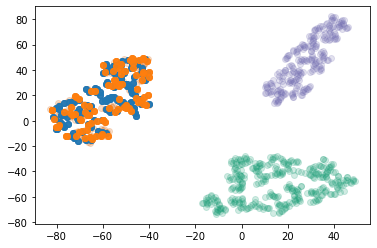

In [137]:
_, ax = plt.subplots()
for class_name, class_label in config['class_name_to_label'].items():
    ax.scatter(
        out_embeddings[target == class_label][:, 0],
        out_embeddings[target == class_label][:, 1],
        label=class_name,
        color=plt.cm.Dark2(class_label),
        alpha=0.2,
        zorder=2)
    
# _, ax = plt.subplots()
for k, v in target_symptom.items():
    ax.scatter(
        out_embeddings[v][:, 0],
        out_embeddings[v][:, 1],
        label=k,
        alpha=0.5,
        zorder=2)